# YOLOv8를 활용한 도로 표지판 탐지 예제

데이터셋 링크
: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection

* 데이터셋 zip파일 이름 변경 -> Road Sign Detection.zip

* MyDrive에 Data 폴더를 생성하고 데이터셋 zip 파일을 넣기 -> '런타임 연결 해제 및 삭제'를 했을 때, 데이터셋 재 업로드의 번거로움 방지.
    * /content/drive/MyDrive/Data 경로에 Road Sign Detection.zip 넣고 실행!

## **1. 구글 드라이브 마운트 및 환경 설정**

런타임이 초기화되어도 ZIP 파일이 안전하게 보관된 드라이브에서 데이터를 가져옵니다.

In [1]:
from google.colab import drive
import torch
import os
import shutil
import random
from pathlib import Path

# 1. 드라이브 마운트
drive.mount('/content/drive')

# 2. GPU 확인 (T4 GPU 권장)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f">>> 현재 사용 중인 디바이스: {device}")

# 3. 경로 설정
# 드라이브 내 ZIP 파일 경로 (박사님께서 설정하신 경로)
zip_path = "/content/drive/MyDrive/Data/Road Sign Detection.zip"

# 작업 루트 폴더 (run time 용도)
root = Path('/content/road_sign_project')
data_dir = root / 'Data'
save_dir = root / 'convert2Yolo'

if root.exists(): shutil.rmtree(root)
for d in [data_dir, save_dir]: d.mkdir(parents=True, exist_ok=True)

# YOLO 표준 데이터 구조 생성
for subset in ['train', 'val', 'test']:
    (save_dir / 'RoadSign' / 'images' / subset).mkdir(parents=True, exist_ok=True)
    (save_dir / 'RoadSign' / 'labels' / subset).mkdir(parents=True, exist_ok=True)

print("환경 설정 및 폴더 구조 생성 완료")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
>>> 현재 사용 중인 디바이스: cuda
환경 설정 및 폴더 구조 생성 완료


## **2. 데이터셋 준비 및 변환 도구 설치**

데이터셋 zip 파일 압축 해제 및 변환 도구 클론

* Yolo2 관련 reference 링크 : https://github.com/ssaru/convert2Yolo.git

* image_b1df8f.png에서 발생한 패키지 충돌을 피하기 위해서, requirements.txt 전체 설치 대신 최신 환경에 맞는 필수 패키지만 설치한다.

In [2]:
# 1. 압축 해제
%cd {data_dir}
!unzip -q "{zip_path}" -d ./temp_raw

# 2. 변환 도구 클론 (폴더명을 명시하여 경로 오류 방지)
%cd {root}
!git clone https://github.com/ssaru/convert2Yolo.git {root}/convert2Yolo_src

# 3. 필수 라이브러리 설치 (requirements.txt 에러 우회)
!pip install ultralytics

# 4. 클래스 정의 (Kaggle Road Sign 데이터셋 전용)
with open(root / 'convert2Yolo_src' / 'road_sign.names', 'w') as f:
    f.write("trafficlight\nspeedlimit\ncrosswalk\nstop")

/content/road_sign_project/Data
/content/road_sign_project
Cloning into '/content/road_sign_project/convert2Yolo_src'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 215 (delta 38), reused 35 (delta 35), pack-reused 172 (from 1)
Receiving objects: 100% (215/215), 994.67 KiB | 21.16 MiB/s, done.
Resolving deltas: 100% (95/95), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.0 MB/s eta 0:00:00


## **3. YOLO 변환**

폴더 경로 설정 및 변환 실행

* 출력 폴더가 비어 있을 때 발생하는 에러를 방지하기 폴더 생성 및 경로를 엄격히 지정한다.

In [3]:
# 5. 변환 결과 저장 폴더 미리 생성 (FileNotFoundError 방지)
temp_label_dir = data_dir / 'temp_raw' / 'labels_yolo'
temp_label_dir.mkdir(parents=True, exist_ok=True)

# 6. 변환 실행
%cd {root}/convert2Yolo_src
!python example.py \
    --datasets VOC \
    --img_path {data_dir}/temp_raw/images \
    --label {data_dir}/temp_raw/annotations \
    --convert_output_path {temp_label_dir} \
    --img_type '.png' \
    --cls_list_file ./road_sign.names

# 7. 변환 결과 샘플 확인 (YOLO 기본 구조 출력)
# 구조: <class_id> <x_center> <y_center> <width> <height>
label_sample = os.listdir(temp_label_dir)
if label_sample:
    print(f"\nYOLO 라벨 샘플 ({label_sample[0]}):")
    !head -n 5 {temp_label_dir}/{label_sample[0]}
else:
    print("변환 실패: 라벨 파일이 생성되지 않았습니다.")

/content/road_sign_project/convert2Yolo_src

VOC Parsing:   |████████████████████████████████████████| 100.0% (877/877)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (877/877)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (877/877)  Complete


YOLO 라벨 샘플 (road109.txt):
1 0.649 0.506 0.083 0.112


## **4. 데이터 분할 및 이동**

이미지 데이터 배분 비율

* Train : Val : Test = 7 : 1 : 2

In [4]:
# 파일 리스트 확보 및 셔플
all_imgs = sorted([f for f in os.listdir(data_dir / 'temp_raw/images') if f.endswith('.png')])
random.seed(42)
random.shuffle(all_imgs)

total = len(all_imgs)
n_train = int(total * 0.7)
n_val = int(total * 0.1)

train_files = all_imgs[:n_train]
val_files = all_imgs[n_train:n_train + n_val]
test_files = all_imgs[n_train + n_val:]

def distribute_data(files, subset):
    for f in files:
        # 이미지 이동
        shutil.move(data_dir / f"temp_raw/images/{f}", save_dir / f"RoadSign/images/{subset}/{f}")
        # 라벨 이동
        lbl = f.replace('.png', '.txt')
        if (temp_label_dir / lbl).exists():
            shutil.move(temp_label_dir / lbl, save_dir / f"RoadSign/labels/{subset}/{lbl}")

distribute_data(train_files, 'train')
distribute_data(val_files, 'val')
distribute_data(test_files, 'test')

print(f"분할 완료: Train({len(train_files)}), Val({len(val_files)}), Test({len(test_files)})")

분할 완료: Train(613), Val(87), Test(177)


## **5. YOLOv8s 모델 학습**

학습 결과 저장 경로

* runs/detect/custom_s 폴더에 저장

In [5]:
# 학습 설정 파일(YAML) 생성
yaml_path = root / 'road_sign_data.yaml'
with open(yaml_path, 'w') as f:
    f.write(f"path: {save_dir}/RoadSign\ntrain: images/train\nval: images/val\ntest: images/test\nnc: 4\nnames: ['trafficlight', 'speedlimit', 'crosswalk', 'stop']")

from ultralytics import YOLO

# 모델 로드 및 학습 (결과 폴더: custom_s)
model = YOLO('yolov8s.pt')
model.train(
    data=str(yaml_path),
    epochs=30, # <= 에포크 조정
    batch=16,
    imgsz=640,
    device=0,
    name='custom_s'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/road_sign_project/road_sign_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x797e86be3fb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## **6. 탐지 결과 시각화**

학습된 best.pt로 테스트 이미지를 탐지하고 화면에 출력한다.

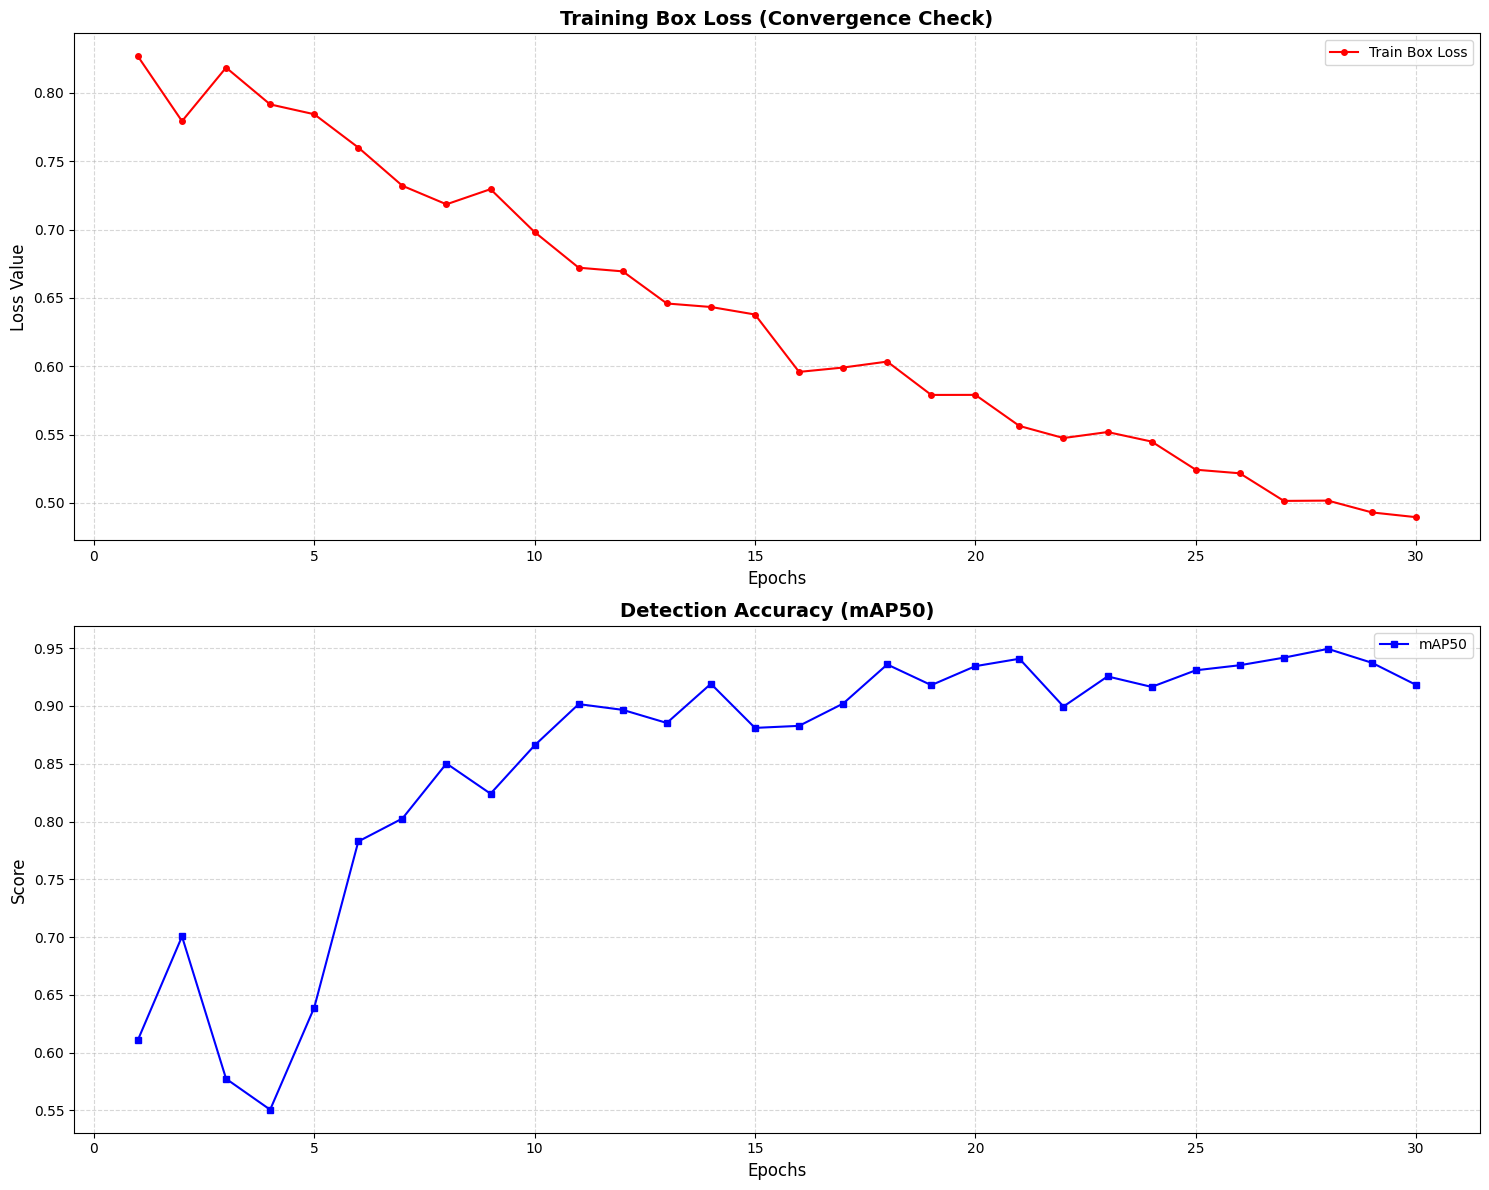

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. results.csv 파일 경로 설정 (박사님의 경로 확인 필요)
results_csv = f'{root}/convert2Yolo_src/runs/detect/custom_s/results.csv'

if os.path.exists(results_csv):
    # 2. 데이터 불러오기 및 컬럼명 정리 (공백 제거)
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()

    # 3. 2행 1열 구조로 그래프 그리기 (Loss와 mAP 분리)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))
    max_epoch = df['epoch'].max()

    # --- (A) 상단: Loss 그래프 (Box Loss) ---
    ax[0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='red', marker='o', markersize=4)
    ax[0].set_title("Training Box Loss (Convergence Check)", fontsize=14, fontweight='bold')
    ax[0].set_ylabel("Loss Value", fontsize=12)

    # --- (B) 하단: mAP 지표 그래프 (핵심 지표) ---
    ax[1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', color='blue', marker='s', markersize=4)
    ax[1].set_title("Detection Accuracy (mAP50)", fontsize=14, fontweight='bold')
    ax[1].set_ylabel("Score", fontsize=12)

    for a in ax:
        #a.set_ylim(0., 1.0)              # Y축 최대값 1.0 고정
        a.set_xticks(np.arange(0, max_epoch + 1, 5)) # X축 에포크 5 간격
        a.set_xlabel("Epochs", fontsize=12)
        a.grid(True, linestyle='--', alpha=0.5)
        a.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
else:
    print(f"!!! '{results_csv}' 파일을 찾을 수 없습니다. 학습 완료 여부를 확인해주세요.")

In [29]:
# 1. 테스트 이미지 탐지 수행 (반드시 이 셀을 먼저 실행해야 폴더가 생성됩니다)
test_img_dir = f"{save_dir}/RoadSign/images/test"
results = model.predict(
    source=test_img_dir,
    save=True,
    conf=0.3,
    name='predict_custom', # 이 이름으로 폴더가 생성됩니다
    exist_ok=True          # 동일 이름 폴더가 있어도 덮어쓰기 허용
)

# 2. 16개 결과 이미지 4행 4열 시각화
predict_dir = f'{root}/convert2Yolo_src/runs/detect/predict_custom'
pred_files = sorted([f for f in os.listdir(predict_dir) if f.endswith(('.jpg', '.png'))])[:16]

plt.figure(figsize=(24, 24))
for i, img_name in enumerate(pred_files):
    plt.subplot(4, 4, i + 1)
    img = mpimg.imread(os.path.join(predict_dir, img_name))
    plt.imshow(img)
    plt.title(img_name, fontsize=10)
    plt.axis('off')
plt.suptitle("Road Sign Detection: 16 Samples", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# **7. YOLOv8 학습 결과 및 예측 이미지 종합 시각화**

그래프, 이미지 결과물 출력하기.

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from pathlib import Path

# 1. 경로 설정 (박사님의 최신 설정 반영)
# 결과 폴더: custom_s
# 예측 폴더: predict_custom
result_dir = Path('/content/road_sign_project/convert2Yolo_src/runs/detect/custom_s')
predict_dir = Path('/content/road_sign_project/convert2Yolo_src/runs/detect/predict_custom')

# 이미지 출력용 헬퍼 함수
def plot_grid(image_paths, rows, cols, figsize, title):
    valid_paths = [p for p in image_paths if os.path.exists(p)]
    if not valid_paths:
        print(f"!! {title}: 표시할 파일이 없습니다. 경로를 확인해주세요.")
        return

    plt.figure(figsize=figsize)
    for i, img_path in enumerate(valid_paths[:rows*cols]):
        plt.subplot(rows, cols, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=10)
        plt.axis('off')
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

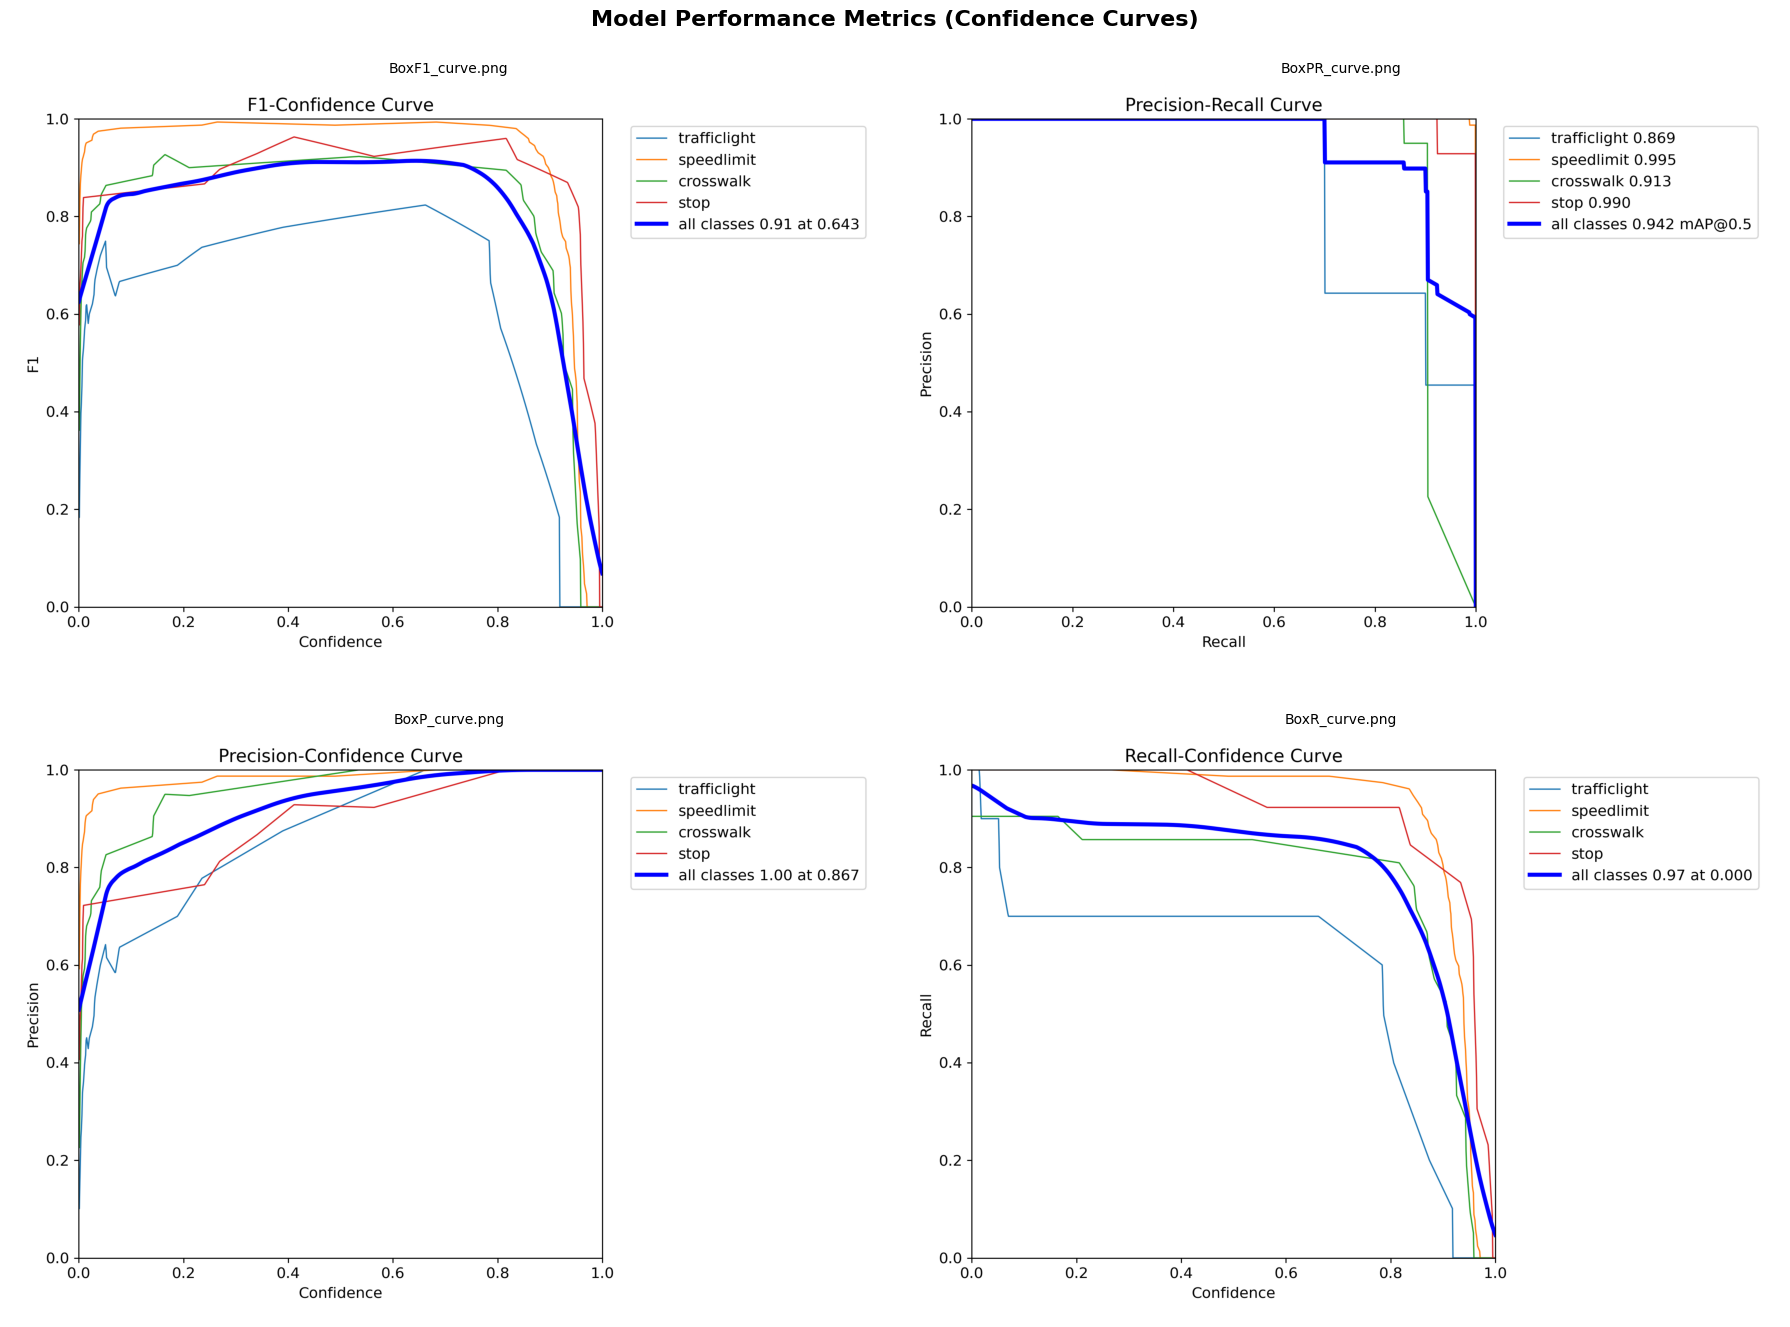

In [32]:
# --- (A) Metric Curves (2행 2열) ---
#
metrics = [result_dir / f for f in ['BoxF1_curve.png', 'BoxPR_curve.png', 'BoxP_curve.png', 'BoxR_curve.png']]
plot_grid(metrics, 2, 2, (18, 14), "Model Performance Metrics (Confidence Curves)")

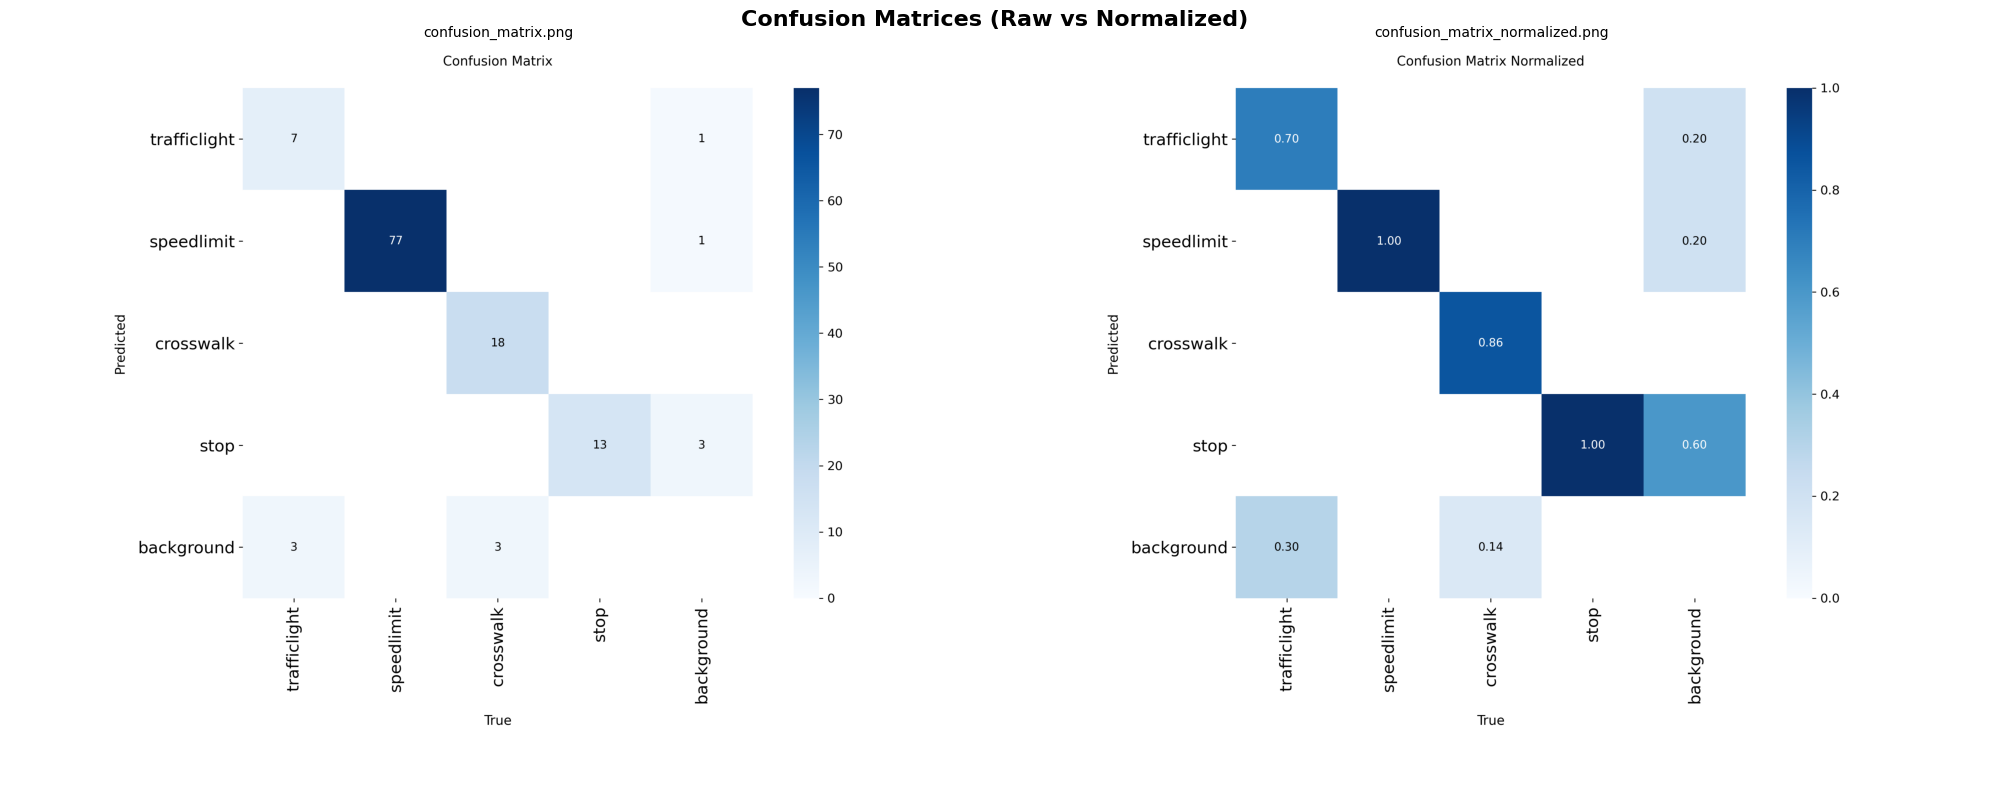

In [33]:
# --- (B) Confusion Matrices (1행 2열) ---
#
cms = [result_dir / f for f in ['confusion_matrix.png', 'confusion_matrix_normalized.png']]
plot_grid(cms, 1, 2, (20, 8), "Confusion Matrices (Raw vs Normalized)")

In [45]:
# --- (C) Training & Validation Batches ---
#
train_batches = sorted([str(result_dir / f) for f in os.listdir(result_dir) if f.startswith('train_batch')])
plot_grid(train_batches, 3, 2, (15, 22), "Training Data Batches (Augmentation)")

val_batches = sorted([str(result_dir / f) for f in os.listdir(result_dir) if f.startswith('val_batch')])
plot_grid(val_batches, 2, 2, (12, 12), "Validation Batches (Labels vs Predictions)")

Output hidden; open in https://colab.research.google.com to view.

커스텀 분석 결과가 '/content/road_sign_project/convert2Yolo_src/runs/detect/custom_s/results.png'에 성공적으로 저장되었습니다.


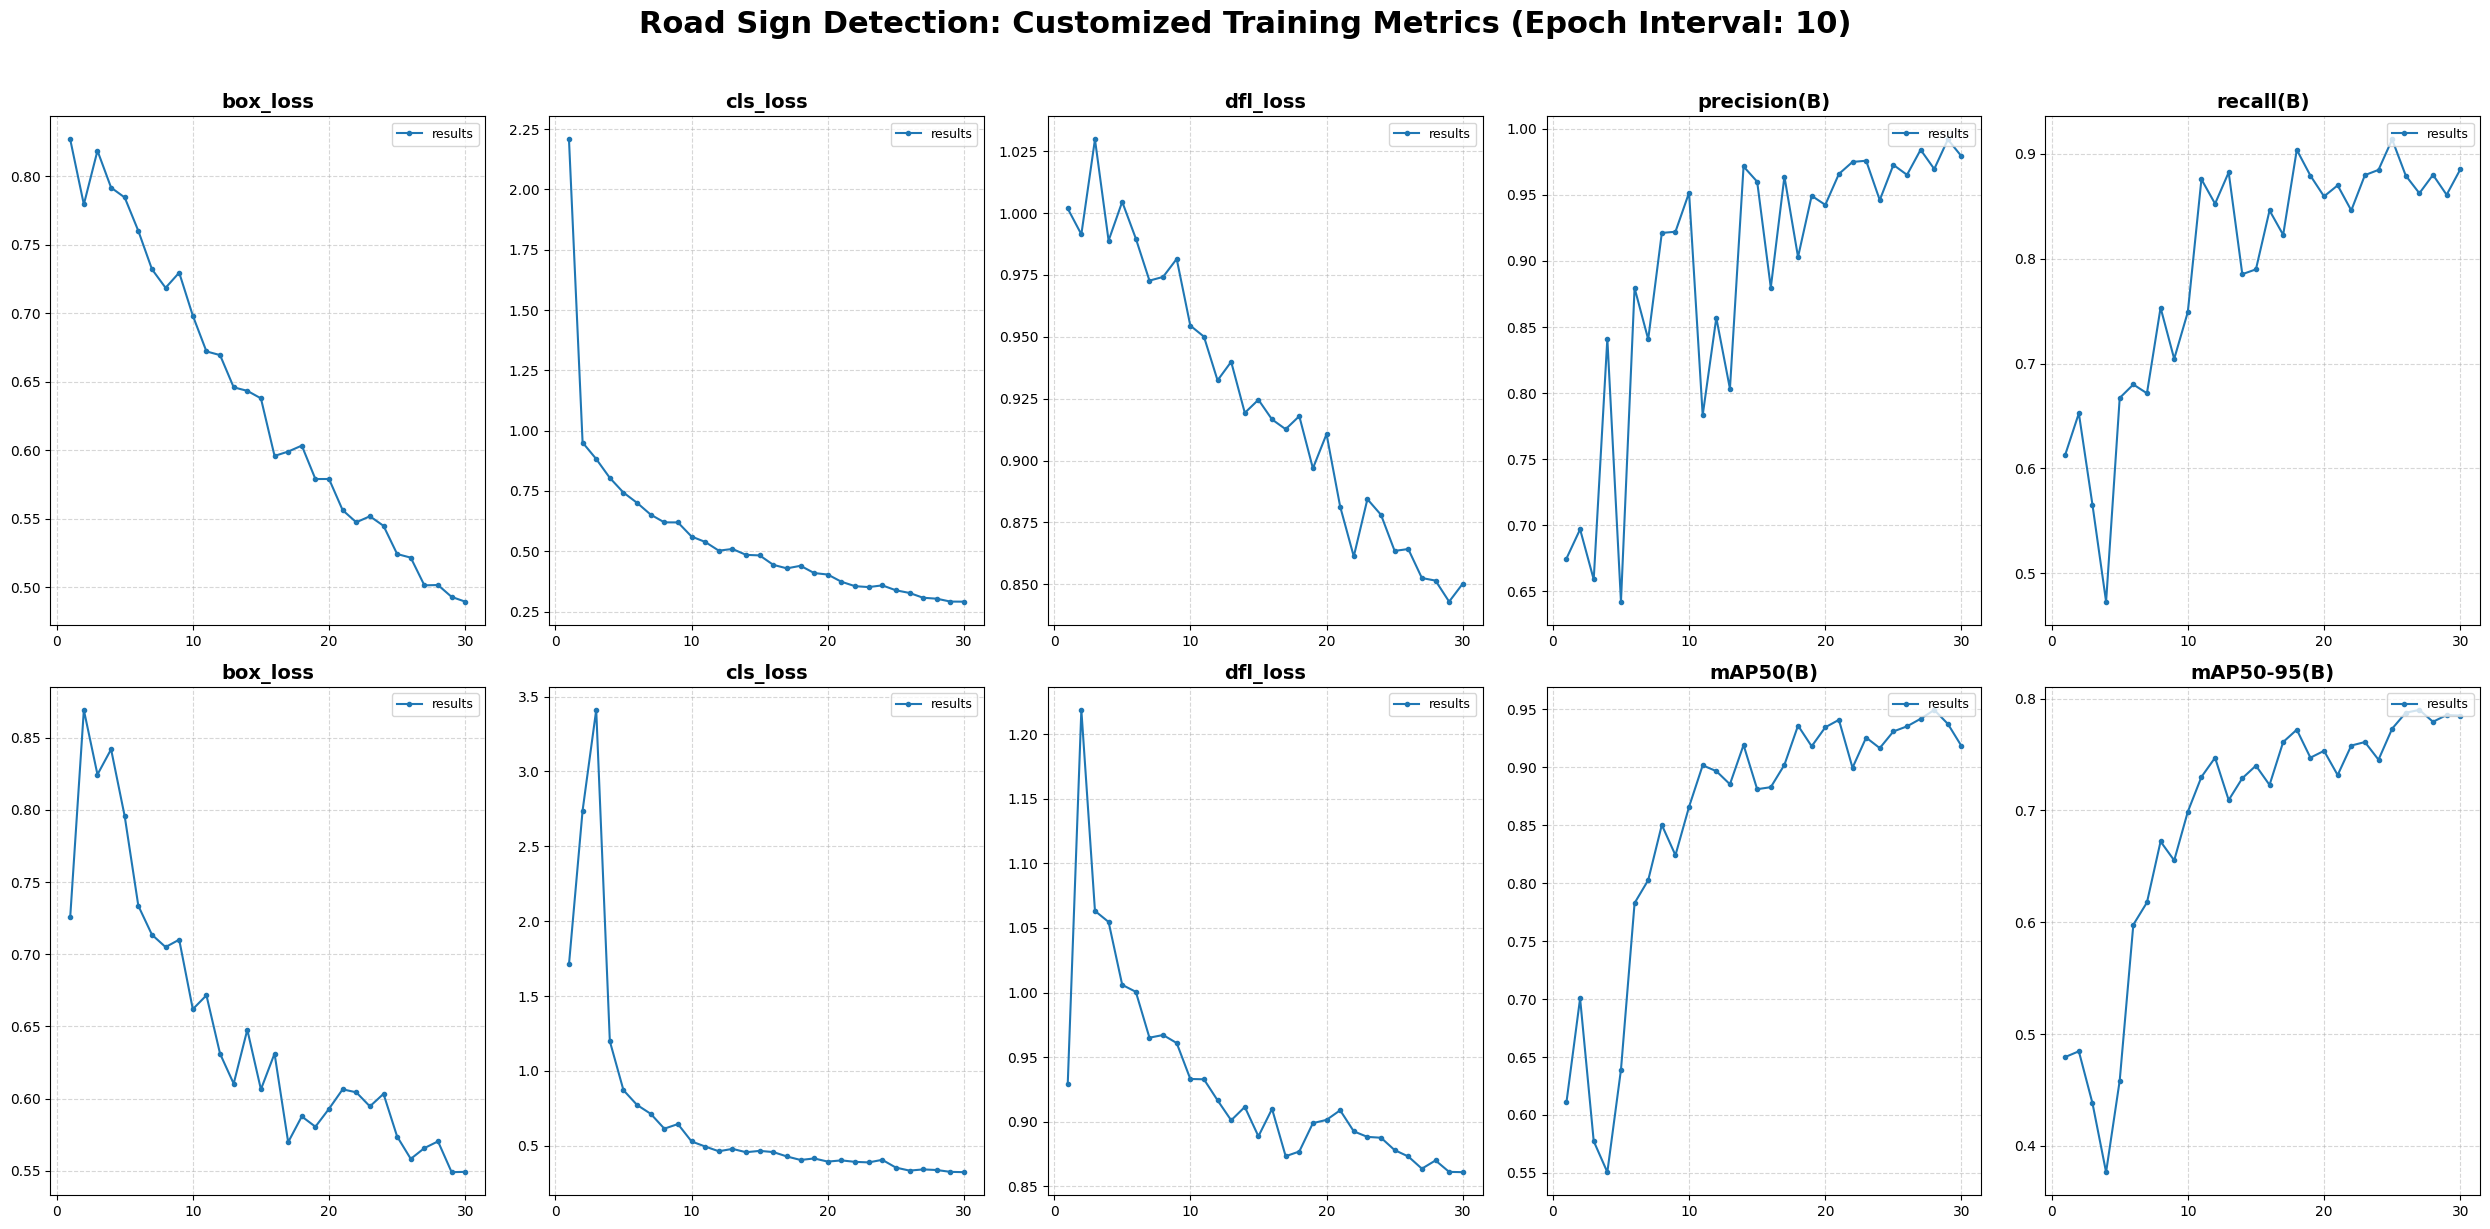

In [35]:
# --- (D) Overall Results (results.png) ---

# 1. 데이터 경로 설정
results_csv = f'{root}/convert2Yolo_src/runs/detect/custom_s/results.csv'
# 저장할 경로 (기존 results.png를 덮어씌웁니다)
save_path = f'{root}/convert2Yolo_src/runs/detect/custom_s/results.png'

if os.path.exists(results_csv):
    # 2. 데이터 로드 및 정리
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    max_epoch = df['epoch'].max()

    # 3. 2행 5열 서브플롯 생성
    # plt.subplots를 직접 사용하므로 imshow 시 발생하던 가장자리 외곽 눈금이 나타나지 않습니다.
    fig, axes = plt.subplots(2, 5, figsize=(25, 12))

    metrics = [
        'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)',
        'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)'
    ]

    for i, metric in enumerate(metrics):
        row, col = i // 5, i % 5
        ax = axes[row, col]

        # 데이터 플로팅
        ax.plot(df['epoch'], df[metric], marker='o', markersize=3, label='results', color='tab:blue')
        ax.set_title(metric.split('/')[-1], fontsize=14, fontweight='bold')
        ax.set_xticks(np.arange(0, max_epoch + 1, 10))

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.legend(fontsize=9, loc='upper right')

    # 전체 레이아웃 조정
    plt.suptitle("Road Sign Detection: Customized Training Metrics (Epoch Interval: 10)",
                 fontsize=22, fontweight='bold', y=1.02)
    plt.tight_layout()

    # 결과를 results.png 파일로 저장
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"커스텀 분석 결과가 '{save_path}'에 성공적으로 저장되었습니다.")

    plt.show()

In [43]:
# --- (E) Prediction Results (4행 4열 - 16개) ---

# 1. 경로 설정
predict_dir = Path(f'{root}/convert2Yolo_src/runs/detect/predict_custom')
save_test_path = predict_dir / 'test.png'

if predict_dir.exists():
    # 2. 이미지 파일 목록 확보 (상위 16개)
    pred_files = sorted([predict_dir / f for f in os.listdir(predict_dir) if f.lower().endswith(('.jpg', '.png'))])[:16]

    # 3. 4x4 그리드 시각화 설정
    plt.figure(figsize=(24, 24))
    for i, img_path in enumerate(pred_files):
        plt.subplot(4, 4, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=18, fontweight='bold')
        plt.axis('off') # 외곽 축 제거

    plt.suptitle("YOLOv8 Road Sign Detection: 16 Test Samples", fontsize=30, fontweight='bold', y=1.02)
    plt.tight_layout()

    # 4. test.png로 저장 (DPI 설정을 통해 고화질 저장)
    plt.savefig(save_test_path, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"예측 결과 그리드가 '{save_test_path}'에 성공적으로 저장되었습니다.")
else:
    print("!!! predict_custom 폴더가 존재하지 않습니다. 먼저 model.predict()를 실행하세요.")

Output hidden; open in https://colab.research.google.com to view.